In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [8]:
spot = pd.read_csv(
    "data/processed/nifty_spot_clean_5min.csv",
    parse_dates=['date'],
    index_col='date'
)
spot['log_return'] = np.log(spot['close']).diff()

# Load regimes from Task 3 output
regimes = pd.read_csv(
    "data/processed/hmm_regimes.csv",
    parse_dates=['date'],
    index_col='date'
)


In [9]:
spot[['close','log_return']].head()


,close,log_return
date,,
2024-07-25 15:25:00,24415.00,NaN
2024-07-26 09:15:00,24467.45,0.002146
2024-07-26 09:20:00,24477.45,0.000409
2024-07-26 09:25:00,24477.20,-0.000010
2024-07-26 09:30:00,24490.45,0.000541


In [10]:
spot = spot.merge(regimes, left_index=True, right_index=True, how='left')



In [11]:
spot[['close','regime']].dropna().head()


,close,regime
date,,
2024-07-26 09:15:00,24467.45,-1.0
2024-07-26 09:20:00,24477.45,-1.0
2024-07-26 09:25:00,24477.20,-1.0
2024-07-26 09:30:00,24490.45,-1.0
2024-07-26 09:35:00,24513.55,-1.0


In [12]:
#Generating trading signals

In [13]:
spot['signal'] = 0

spot.loc[spot['regime'] == 1, 'signal'] = 1
spot.loc[spot['regime'] == -1, 'signal'] = -1


In [14]:
spot['signal'] = spot['signal'].shift(1)


In [15]:
spot['strategy_return'] = spot['signal'] * spot['log_return']


In [16]:
spot['cum_market'] = np.exp(spot['log_return'].cumsum())
spot['cum_strategy'] = np.exp(spot['strategy_return'].cumsum())


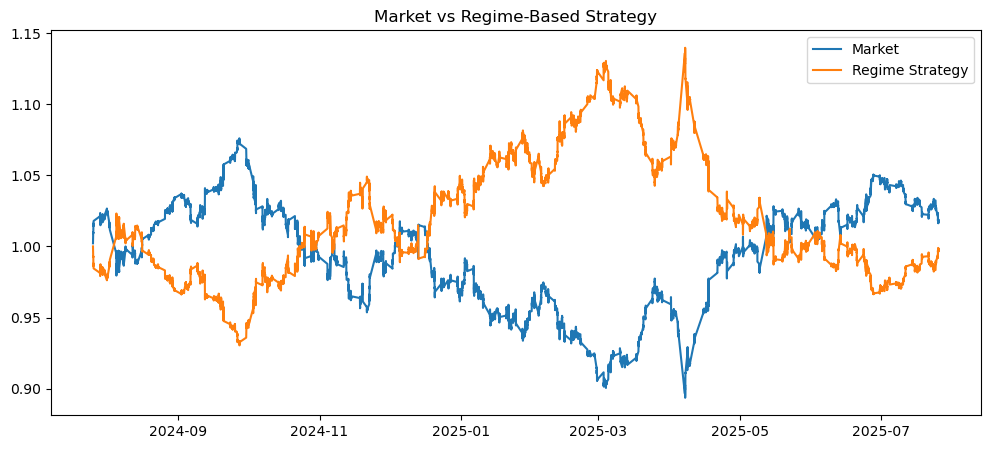

In [17]:
plt.figure(figsize=(12,5))
plt.plot(spot['cum_market'], label='Market')
plt.plot(spot['cum_strategy'], label='Regime Strategy')
plt.legend()
plt.title("Market vs Regime-Based Strategy")
plt.show()


In [18]:
def sharpe(returns, freq=252*78):  # 5-min bars
    return np.sqrt(freq) * returns.mean() / returns.std()

metrics = {
    "Total Return": spot['strategy_return'].sum(),
    "Sharpe Ratio": sharpe(spot['strategy_return']),
    "Win Rate": (spot['strategy_return'] > 0).mean(),
    "Max Drawdown": (
        spot['cum_strategy'] /
        spot['cum_strategy'].cummax() - 1
    ).min()
}

metrics


{'Total Return': np.float64(-0.001909648814024223),
 'Sharpe Ratio': np.float64(-0.015045067707886495),
 'Win Rate': np.float64(0.4947526236881559),
 'Max Drawdown': -0.15203856702402097}

In [19]:
spot['signal'].value_counts()


signal
-1.0    18444
 0.0      224
 1.0        7
Name: count, dtype: int64

In [20]:
spot[['close','regime','signal','strategy_return','cum_strategy']] \
    .to_csv("data/processed/strategy_results.csv")


In [21]:
spot['ema_5'] = spot['close'].ewm(span=5, adjust=False).mean()
spot['ema_15'] = spot['close'].ewm(span=15, adjust=False).mean()


In [22]:
spot['ema_5'] = spot['close'].ewm(span=5, adjust=False).mean()
spot['ema_15'] = spot['close'].ewm(span=15, adjust=False).mean()


In [23]:
spot['ema_5'] = spot['close'].ewm(span=5, adjust=False).mean()
spot['ema_15'] = spot['close'].ewm(span=15, adjust=False).mean()


In [24]:
spot['ema_signal'] = 0

# Bullish crossover → +1
spot.loc[
    (spot['ema_5'] > spot['ema_15']) &
    (spot['ema_5'].shift(1) <= spot['ema_15'].shift(1)),
    'ema_signal'
] = 1

# Bearish crossover → -1
spot.loc[
    (spot['ema_5'] < spot['ema_15']) &
    (spot['ema_5'].shift(1) >= spot['ema_15'].shift(1)),
    'ema_signal'
] = -1


In [25]:
spot['ema_signal'].value_counts()


ema_signal
 0    17374
 1      651
-1      651
Name: count, dtype: int64

In [26]:
spot['trade_signal'] = 0

# LONG entry
spot.loc[
    (spot['ema_signal'] == 1) &
    (spot['regime'] == 1),
    'trade_signal'
] = 1

# SHORT entry
spot.loc[
    (spot['ema_signal'] == -1) &
    (spot['regime'] == -1),
    'trade_signal'
] = -1


In [27]:
spot['position'] = spot['trade_signal'].replace(to_replace=0, method='ffill')
spot['position'] = spot['position'].shift(1)
spot['position'].fillna(0, inplace=True)


C:\Users\91969\AppData\Local\Temp\ipykernel_21100\3455332429.py:1: FutureWarning: The 'method' keyword in Series.replace is deprecated and will be removed in a future version.
  spot['position'] = spot['trade_signal'].replace(to_replace=0, method='ffill')
C:\Users\91969\AppData\Local\Temp\ipykernel_21100\3455332429.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  spot['position'].fillna(0, inplace=True)


In [28]:
spot['strategy_return'] = spot['position'] * spot['log_return']


In [29]:
split_idx = int(len(spot) * 0.7)

train = spot.iloc[:split_idx]
test = spot.iloc[split_idx:]


# Backtesting Metrics


In [30]:
def sharpe(returns, freq=252*78):
    return np.sqrt(freq) * returns.mean() / returns.std()

def sortino(returns, freq=252*78):
    downside = returns[returns < 0]
    return np.sqrt(freq) * returns.mean() / downside.std()

def max_drawdown(cum_returns):
    return (cum_returns / cum_returns.cummax() - 1).min()


In [31]:
test['cum_strategy'] = np.exp(test['strategy_return'].cumsum())


C:\Users\91969\AppData\Local\Temp\ipykernel_21100\1097147482.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['cum_strategy'] = np.exp(test['strategy_return'].cumsum())


In [32]:
trades = test['position'].diff().abs()
total_trades = trades.sum() / 2

win_rate = (test['strategy_return'] > 0).mean()

profit_factor = (
    test.loc[test['strategy_return'] > 0, 'strategy_return'].sum() /
    abs(test.loc[test['strategy_return'] < 0, 'strategy_return'].sum())
)


In [33]:
trades = test['position'].diff().abs()
total_trades = trades.sum() / 2

win_rate = (test['strategy_return'] > 0).mean()

profit_factor = (
    test.loc[test['strategy_return'] > 0, 'strategy_return'].sum() /
    abs(test.loc[test['strategy_return'] < 0, 'strategy_return'].sum())
)


In [34]:
metrics = {
    "Total Return": test['strategy_return'].sum(),
    "Sharpe Ratio": sharpe(test['strategy_return']),
    "Sortino Ratio": sortino(test['strategy_return']),
    "Max Drawdown": max_drawdown(test['cum_strategy']),
    "Win Rate": win_rate,
    "Profit Factor": profit_factor,
    "Total Trades": total_trades
}

metrics


{'Total Return': np.float64(-0.10355803192727286),
 'Sharpe Ratio': np.float64(-2.907975783911673),
 'Sortino Ratio': np.float64(-2.9869974852236707),
 'Max Drawdown': -0.12877813128713744,
 'Win Rate': np.float64(0.49919685882562914),
 'Profit Factor': np.float64(0.927577797682991),
 'Total Trades': np.float64(0.0)}

In [35]:
metrics["Calmar Ratio"] = (
    metrics["Total Return"] / abs(metrics["Max Drawdown"])
)


In [36]:
# Identify trade blocks
trade_blocks = test['position'].ne(test['position'].shift()).cumsum()

# Only keep active trades
active_trades = test[test['position'] != 0].copy()
active_trades['trade_id'] = trade_blocks[test['position'] != 0]

avg_trade_duration = (
    active_trades
    .groupby('trade_id')
    .size()
    .mean()
)

metrics["Average Trade Duration (bars)"] = avg_trade_duration

In [37]:
pd.Series(metrics)


Total Return                       -0.103558
Sharpe Ratio                       -2.907976
Sortino Ratio                      -2.986997
Max Drawdown                       -0.128778
Win Rate                            0.499197
Profit Factor                       0.927578
Total Trades                        0.000000
Calmar Ratio                       -0.804159
Average Trade Duration (bars)    5603.000000
dtype: float64

In [38]:
#final equity curve 

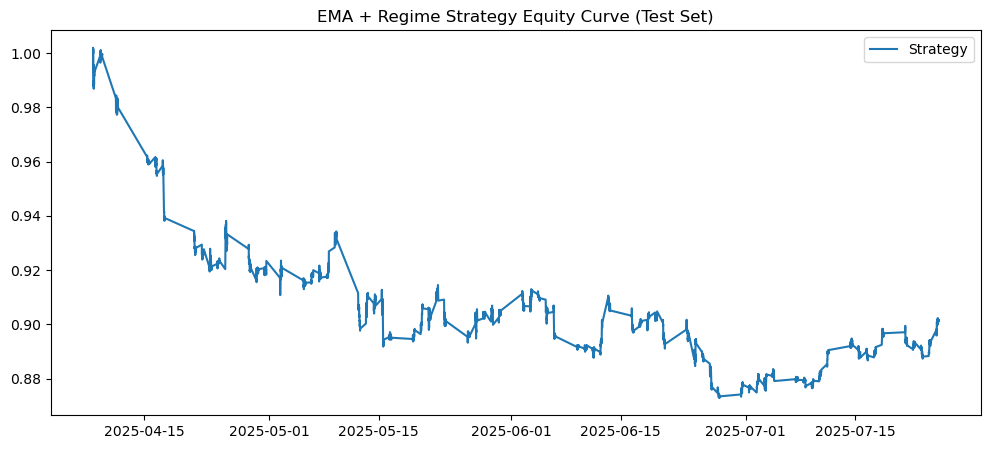

In [39]:
plt.figure(figsize=(12,5))
plt.plot(test.index, test['cum_strategy'], label='Strategy')
plt.title("EMA + Regime Strategy Equity Curve (Test Set)")
plt.legend()
plt.show()


In [41]:
test[['close','ema_5','ema_15','regime','position',
      'strategy_return','cum_strategy']] \
    .to_csv("data/processed/ema_regime_strategy_results.csv")
